In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## 📟 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기

### 📃 프로젝트 1-1.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

#### 1️⃣ 높은 해상도 가진 이미지 불러오기

In [3]:
image = cv2.imread('/content/gdrive/MyDrive/AIFFEL/익스16/Italy.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#### 2️⃣ 원본 이미지에 bicubic imterpolation 적용 (픽셀 수 1/4로 줄이기)

In [4]:
bicubic_image = cv2.resize(
    image, 
    dsize=(image.shape[1]//4, image.shape[0]//4), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

#### DIV2K 데이터셋에서 학습된 모델 srgan_G.h5 불러오기

In [5]:
model_file = '/content/gdrive/MyDrive/AIFFEL/익스16/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

#### apply_srgan 함수

In [6]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

#### 3️⃣ 줄인 저해상도 이미지 -> SRGAN으로 고해상도 이미지 생성

In [7]:
srgan_hr = apply_srgan(bicubic_image)

#### 4️⃣ step 2의 이미지에 bicubic interpolation 적용 (픽셀 수 다시 4배로 늘리기)

In [8]:
bicubic_hr = cv2.resize(
    bicubic_image, 
    dsize=(bicubic_image.shape[1]*4, bicubic_image.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

####  5️⃣ step 4의  bicubic 결과, step 3의 SRGAN 결과, step 1의 원본 고해상도 이미지 => 시각화하기

/usr/local/lib/python3.7/dist-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


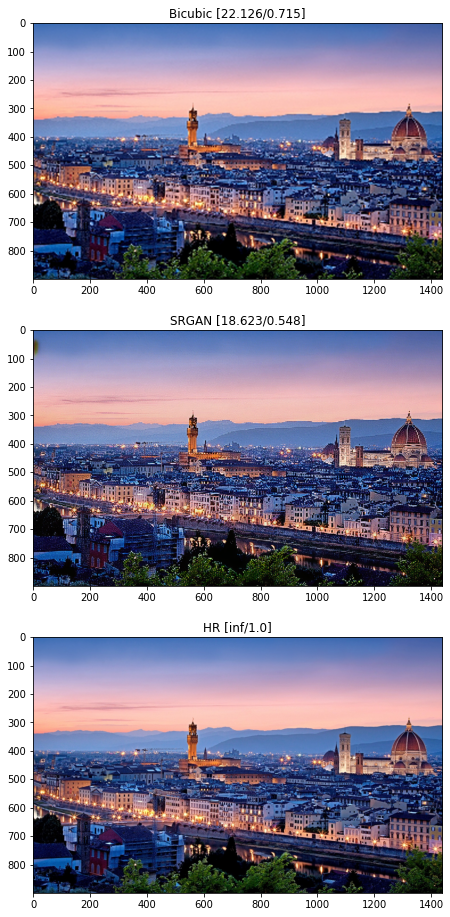

In [9]:
images = [bicubic_hr, srgan_hr, image]
titles = ["Bicubic", "SRGAN", "HR"]

# 각 이미지에 대해 PSNR을 계산하고 반올림합니다.
psnr = [round(peak_signal_noise_ratio(image, i), 3) for i in images]
# 각 이미지에 대해 SSIM을 계산하고 반올림합니다.
ssim = [round(structural_similarity(image, i, multichannel=True), 3) for i in images]

# 이미지 제목에 PSNR과 SSIM을 포함하여 시각화 합니다. 
plt.figure(figsize=(16,16))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.imshow(images[i])
    plt.title(titles[i] + f" [{psnr[i]}/{ssim[i]}]", fontsize=12)

#### 특정 부분만 시각화

Text(0.5, 1.0, 'HR')

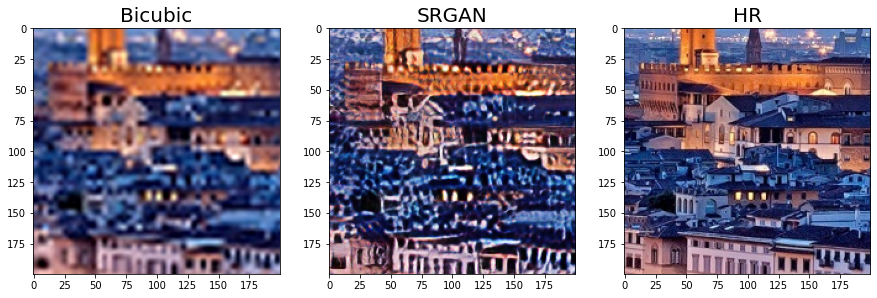

In [10]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

# interpolation된 이미지와 srgan 이미지와 고해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (400, 500)
crop_bicubic_hr = crop(bicubic_hr, left_top)
crop_srgan_hr = crop(srgan_hr, left_top)
crop_image = crop(image, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,25))
plt.subplot(1,3,1); plt.imshow(crop_bicubic_hr); plt.title("Bicubic", fontsize=20)
plt.subplot(1,3,2); plt.imshow(crop_srgan_hr); plt.title("SRGAN", fontsize=20)
plt.subplot(1,3,3); plt.imshow(crop_image); plt.title("HR", fontsize=20)

#### 6️⃣ 결과 설명

### 📃 프로젝트 1-2.

#### 1️⃣ 낮은 해상도 이미지 불러오기

In [11]:
image2 = cv2.imread('/content/gdrive/MyDrive/AIFFEL/익스16/Rome.jpg')
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

#### 2️⃣ 원본 이미지 => SRGAN으로 고해상도 이미지 생성

In [12]:
srgan_hr2 = apply_srgan(image2)

#### 3️⃣ 원본 이미지 => bicubic interpolation 적용 (픽셀 수 4배로 늘리기)

In [13]:
bicubic_hr2 = cv2.resize(
    image2, 
    dsize=(image2.shape[1]*4, image2.shape[0]*4), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

#### 4️⃣  원본 저해상도 이미지, step 3의  bicubic 결과, step 2의 SRGAN 결과 => 시각화

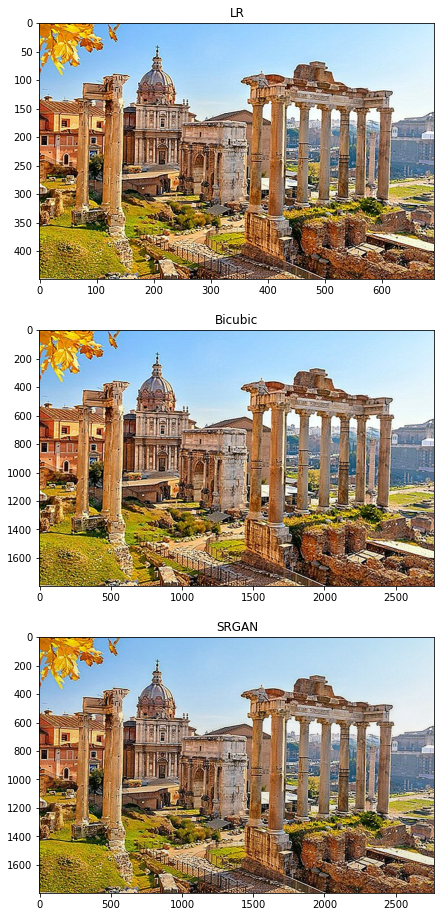

In [14]:
images = [image2,bicubic_hr2, srgan_hr2]
titles = ["LR","Bicubic", "SRGAN"]


plt.figure(figsize=(16,16))
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.imshow(images[i])
    plt.title(titles[i])

#### 특정 부분만 시각화

Text(0.5, 1.0, 'Bicubic')

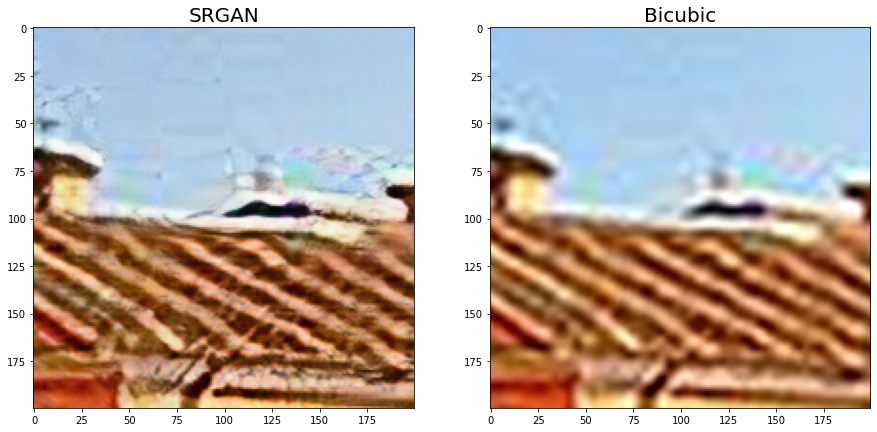

In [15]:
# interpolation된 이미지와 srgan 이미지와 저해상도 이미지의 동일한 부분을 각각 잘라냅니다.
left_top = (450, 60)
crop_bicubic_hr2 = crop(bicubic_hr2, left_top)
crop_srgan_hr2 = crop(srgan_hr2, left_top)

# 잘라낸 부분을 시각화 합니다.
plt.figure(figsize=(15,15))
plt.subplot(1,2,1); plt.imshow(crop_srgan_hr2); plt.title("SRGAN", fontsize=20)
plt.subplot(1,2,2); plt.imshow(crop_bicubic_hr2); plt.title("Bicubic", fontsize=20)

#### 5️⃣ 결과 설명

## 💻 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

### 1. gif 파일 불러오기

In [16]:
gif = cv2.VideoCapture("/content/gdrive/MyDrive/AIFFEL/익스16/city_night_lr.gif")

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)


print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))

frame 수 : 8
frame 크기 : (255, 500, 3)


### 2. 프레임별 Super Resolution 진행하기

In [ ]:
# Bicubic interpolation
Bicubic_frames = []
for frame in frames:
    bc = cv2.resize(
        frame,
        dsize = (frame.shape[1]*4, frame.shape[0]*4),
        interpolation = cv2.INTER_CUBIC
    )
    Bicubic_frames.append(bc)

In [ ]:
frames_sr = []
for frame in frames:
    srgan_frame = apply_srgan(frame)
    frames_sr.append(srgan_frame)

### 3. 프레임을 합쳐 gif 만들기

In [ ]:
import imageio

imageio.mimsave("bicubic.gif", Bicubic_frames)
imageio.mimsave("srgan.gif", frames_sr)

### 4. Jupyter notebook에 gif 표시하기

In [ ]:
from IPython.display import Image as show_gif


### 저해상도.gif

<img src="https://github.com/sjeena0722/AIFFEL/blob/main/EXPLORATION/Ex16_%ED%9D%90%EB%A6%B0%20%EC%82%AC%EC%A7%84%EC%9D%84%20%EC%84%A0%EB%AA%85%ED%95%98%EA%B2%8C/city_night_lr.gif?raw=true" width="800px" height="500"></img>

### bicubic.gif

<img src="bicubic.gif" width="800px" height="500"></img>

### srgan.gif

<img src="srgan.gif" width="800px" height="500"></img>

